# Imports

In [33]:
# General libraries
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn model selection and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Scikit-learn transformers and preprocessors
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

# Scikit-learn regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# External regressor
import xgboost as xgb

# Miscellaneous settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [73]:
houses = pd.read_csv('https://raw.githubusercontent.com/MerleSt/HousingPricePrediction/main/Data/housing_prices.csv')

In [74]:
houses.drop(columns=['Id'], inplace=True)

# Split Data

In [75]:
X = houses.copy()
y = X.pop('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# Temporarily set the display options to show all rows
pd.set_option('display.max_rows', None)

# Display the NaN counts for all columns
print(X_train.isna().sum())

# Reset the display options back to default settings
pd.reset_option('display.max_rows')

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       217
LotArea             0
Street              0
Alley            1094
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          6
MasVnrArea          6
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           28
BsmtCond           28
BsmtExposure       28
BsmtFinType1       28
BsmtFinSF1          0
BsmtFinType2       28
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

# Preprocess Data

In [76]:
num_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

## Encoding

In [77]:
# Define orders
order_LandSlope = ['Sev', 'Mod', 'Gtl']
order_ExterQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_ExterCond = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_BsmtExposure = ['NA', 'No', 'Mn', 'Av', 'Gd']
order_BsmtFinType1 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
order_BsmtFinType2 = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
order_HeatingQC = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_KitchenQual = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
order_FireplaceQu = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_GarageFinish = ['NA', 'Unf', 'RFn', 'Fin']
order_GarageQual = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_GarageCond = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
order_PoolQC = ['NA', 'Fa', 'TA', 'Gd', 'Ex']
order_Fence = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']

# Setup the encoder
ordinal_enc = OrdinalEncoder(
    categories=[
        order_LandSlope, order_ExterQual, order_ExterCond, order_BsmtQual, order_BsmtCond, 
        order_BsmtExposure, order_BsmtFinType1, order_BsmtFinType2, order_HeatingQC, 
        order_KitchenQual, order_FireplaceQu, order_GarageFinish, order_GarageQual, 
        order_GarageCond, order_PoolQC, order_Fence
    ],
    handle_unknown='use_encoded_value',
    unknown_value=-1
)


In [78]:
cat_ordinal = [
    'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
    'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 
    'GarageCond', 'PoolQC', 'Fence'
]
cat_onehot = [col for col in cat_features if col not in cat_ordinal]

## Pipelines

In [79]:
num_pipeline = make_pipeline(
    SimpleImputer()
)

cat_ordinal_pipe = make_pipeline(
    SimpleImputer(strategy='constant'),
    ordinal_enc
)

cat_onehot_pipe = make_pipeline(
    SimpleImputer(strategy='constant'),
    OneHotEncoder(drop='first', handle_unknown='ignore')
)

In [80]:
preprocessor = ColumnTransformer(transformers=[
    ('num_pipe', num_pipeline, num_features),
    ('onehot', cat_onehot_pipe, cat_onehot),
    ('ordinal', cat_ordinal_pipe, cat_ordinal)
])

# Models

In [81]:
models = [DecisionTreeRegressor(random_state=42), SGDRegressor(random_state=42), LinearRegression(), RandomForestRegressor(random_state=42), xgb.XGBRegressor(), 
         Ridge(), Lasso(max_iter=10000), ElasticNet(), SVR(), KNeighborsRegressor(), AdaBoostRegressor(random_state=42)]
model_names = [
    "DecisionTreeRegressor", 
    "SGDRegressor", 
    "LinearRegression", 
    "RandomForestRegressor", 
    "XGBRegressor",
    "Ridge",
    "Lasso",
    "ElasticNet",
    "SVR",
    "KNeighborsRegressor",
    "AdaBoostRegressor"
]

# Pairing models with their names
model_dict = dict(zip(model_names, models))

# Convert the dictionary into a DataFrame
models_df = pd.DataFrame(list(model_dict.items()), columns=['Model_Name', 'Model'])

In [82]:
model_evaluation_metrics = pd.DataFrame(columns=["Model", "MAE", "RMSE", "MAPE", "R2"])

for _, row in models_df.iterrows():
    pipeline = make_pipeline(preprocessor, StandardScaler(), row['Model'])
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    mae = mean_absolute_error(y_true=y_test, y_pred=predictions).round(2)
    rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False).round(2)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=predictions).round(2)
    r2 = r2_score(y_true=y_test, y_pred=predictions).round(2)
    model_name = row['Model_Name']
    
    model_df = pd.DataFrame({
        "Model": [model_name],
        "MAE": [mae],
        "RMSE": [rmse],
        "MAPE": [mape],
        "R2": [r2]},
    )
    
    model_evaluation_metrics = pd.concat([model_evaluation_metrics, model_df], ignore_index=True)

model_evaluation_metrics

Model       MAE       RMSE  MAPE    R2
0   DecisionTreeRegressor  27670.20   43007.32  0.16  0.76
1            SGDRegressor  77650.42  103527.56  0.57 -0.40
2        LinearRegression  22717.26   51741.51  0.13  0.65
3   RandomForestRegressor  17215.80   28560.76  0.10  0.89
4            XGBRegressor  18128.80   32667.88  0.11  0.86
5                   Ridge  21835.15   49055.56  0.13  0.69
6                   Lasso  22097.83   51477.69  0.13  0.65
7              ElasticNet  19587.58   33577.53  0.12  0.85
8                     SVR  59542.35   88646.87  0.36 -0.02
9     KNeighborsRegressor  26172.03   46871.98  0.16  0.71
10      AdaBoostRegressor  24314.55   34448.16  0.17  0.85

# Evaluation Metrics

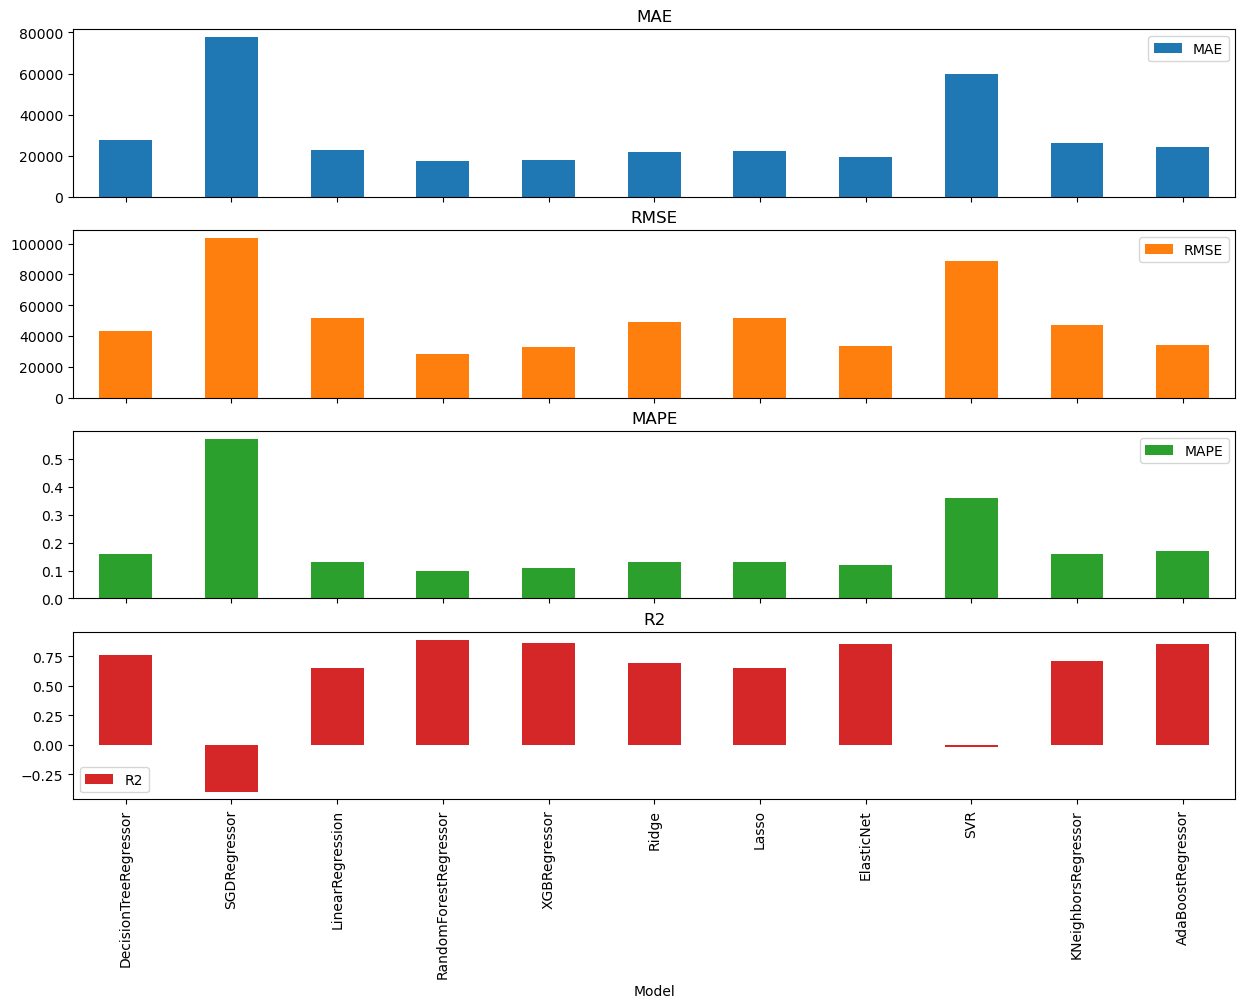

In [12]:
model_evaluation_metrics.plot.bar(subplots=True,
                             figsize=(15, 10),
                                 x='Model');

# Correlation

/var/folders/7h/lk9jxn256x10l_m01pz7khdw0000gn/T/ipykernel_51303/3381050715.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(X_train.corr());


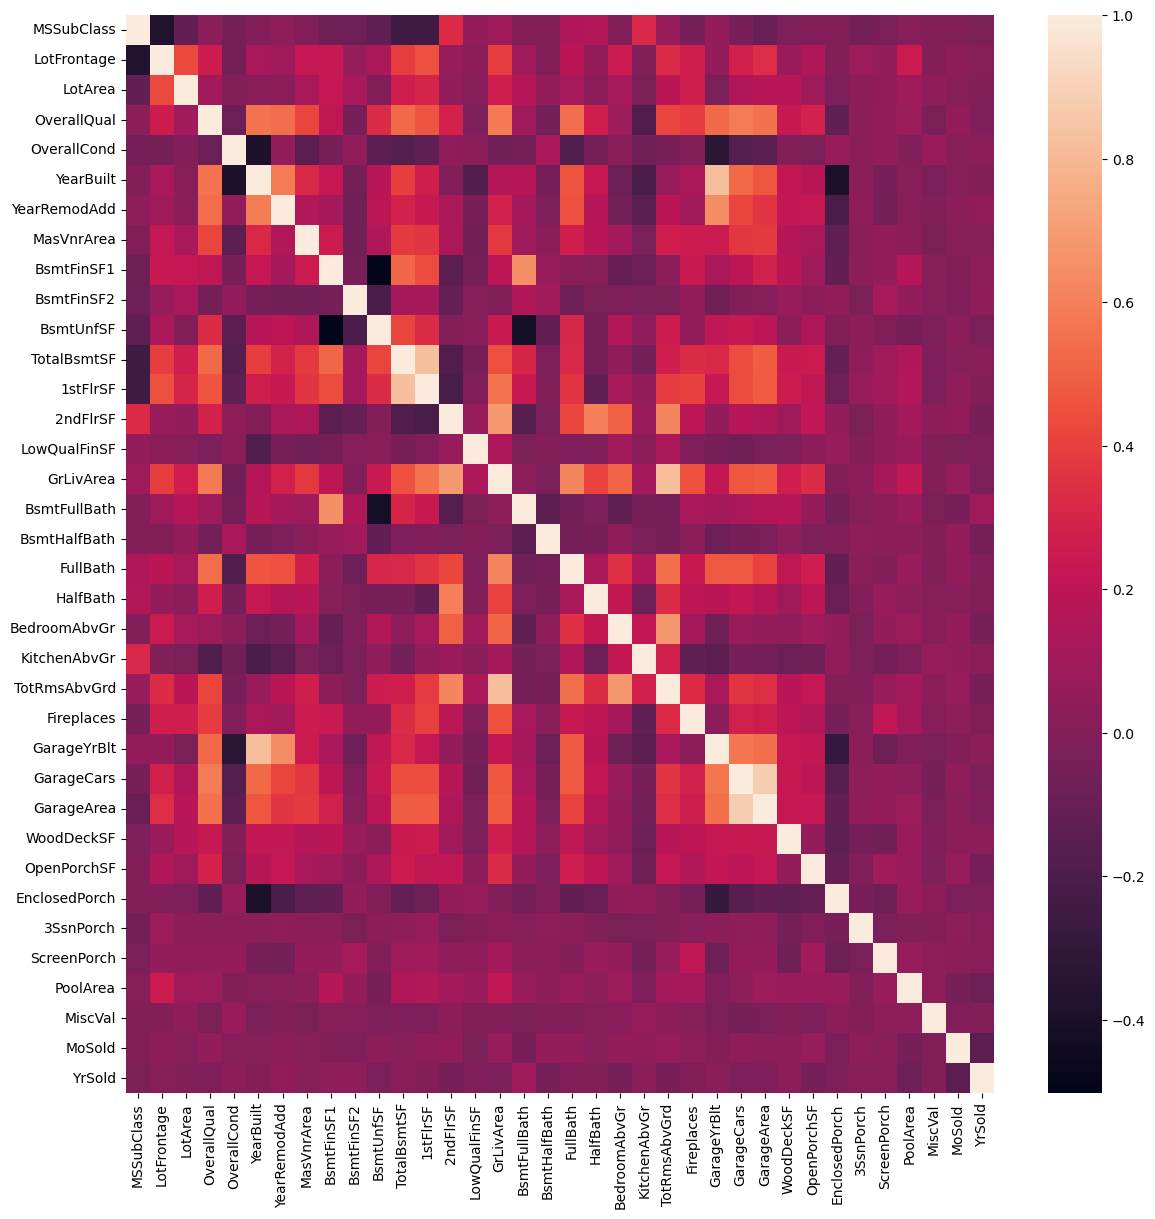

In [15]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(X_train.corr());

In [21]:
corr = X_train.corr(numeric_only=True)
corr_values = corr.unstack()
corr_values = corr_values.loc[corr_values!=1]
corr_values.sort_values(ascending=False)

GarageArea     GarageCars      0.882550
GarageCars     GarageArea      0.882550
TotalBsmtSF    1stFlrSF        0.827382
1stFlrSF       TotalBsmtSF     0.827382
GrLivArea      TotRmsAbvGrd    0.820718
                                 ...   
EnclosedPorch  YearBuilt      -0.392513
BsmtFullBath   BsmtUnfSF      -0.424549
BsmtUnfSF      BsmtFullBath   -0.424549
BsmtFinSF1     BsmtUnfSF      -0.502012
BsmtUnfSF      BsmtFinSF1     -0.502012
Length: 1260, dtype: float64

In [22]:
sns.pairplot(X_train)

# Display the plot
plt.show()

# The End

In [13]:
print('This worked well!')

This worked well!
